<H3>Trabalho Prático 1 - Algoritmos 2 2024.1 UFMG</H3>
Membros:

* Gabriel Arcanjo Campelo Fadoul - 2021031645

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from TriangulacaoPronta import *

<H4> Carga das instâncias de testes

In [24]:
with open("instances\\agp2009a-orthorand\\agp2009a-orthorand\\random-20-2.pol") as f:
    line = f.readline()
    
    file_values = line.split()
total_vertices = int(file_values[0])

G = Grafo()

#Adiciona Vértices no Grafo
V = []
for i in range(1,len(file_values),2):
    X, Y = file_values[i], file_values[i+1]
    
    a, b = X.split("/")
    coord_x = float(a) / float(b)
    
    a, b = Y.split("/")
    coord_y = float(a) / float(b)
    
    V.append(Ponto(coord_x, coord_y))
    G.adicionar_vertice(Ponto(coord_x, coord_y))

# Adiciona Arestas no Grafo
for i in range(len(V)-1):
    G.adicionar_aresta(Vector(G.vertices[i],G.vertices[i+1]))
G.adicionar_aresta(Vector(G.vertices[len(V)-1],G.vertices[0]))

In [25]:
file_values = line.split()
total_vertices = int(file_values[0])

G = Grafo()

#Adiciona Vértices no Grafo
V = []
for i in range(1,len(file_values),2):
    X, Y = file_values[i], file_values[i+1]
    
    a, b = X.split("/")
    coord_x = float(a) / float(b)
    
    a, b = Y.split("/")
    coord_y = float(a) / float(b)
    
    V.append(Ponto(coord_x, coord_y))
    G.adicionar_vertice(Ponto(coord_x, coord_y))

# Adiciona Arestas no Grafo
for i in range(len(V)-1):
    G.adicionar_aresta(Vector(G.vertices[i],G.vertices[i+1]))
G.adicionar_aresta(Vector(G.vertices[len(V)-1],G.vertices[0]))

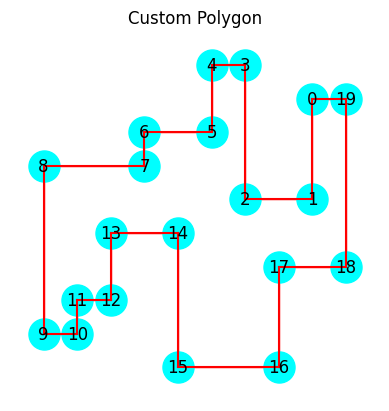

In [26]:
plot_custom_polygon(G.graph,G.vertices,G.arestas)

In [37]:
#df = px.data.gapminder()
v = list(map(lambda P: (P.x,P.y),V))

fig = px.line(x=np.array(v)[:,0],y=np.array(v)[:,1],markers=True)
fig.update_traces(marker_size=10)
fig.show()

<H4>Funções Primitivas de Geometria Computacional

<H4>Funções de Triangulação

<H4>Animações